# WaterMeter - François Goujon

In [2]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
import os
import random
from tqdm import tqdm
import time
import pandas as pd

In [4]:
IMG_DIR = 'pictures/'

### Preprocessing des images avec OpenCV

On essaie différentes fonctions de preprocessing classiques pour voir ce qui pourrait nous être le plus utile : 
- grayscaling
- thresholding
- dilating
- eroding
- opening
- canny edge detection
- noise removal
- deskwing
- template matching. 

In [5]:
# grayscale 
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#  thresholding avec valeur de seuil 
def thresholding(image, seuil):
    return cv2.threshold(image, seuil, 255, cv2.THRESH_BINARY)[1]
 
#  thresholding avec valeur de seuil automatique via optimisation OTSU
def thresholdingOTSU(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# adaptative thresholing (utilise un kernel)
def adaptativethresholing(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

# dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
# erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

# opening - erosion puis dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image, t1 = 100, t2= 200, ap = 3):
    return cv2.Canny(image, t1, t2, apertureSize = ap)

# correction de l'angle
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# Plot des images 
def plotimages(images, cmap = 'gray'):
    keys = list(images.keys())
    taille = len(keys)
    columns = 2
    if taille%2 == 0:
        rows = taille//2
    else :
        rows = taille//2 + 1
    fig = plt.figure(figsize=(8*columns,8*rows))
    ax = []
    
    for i in range(taille):
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title('Image - ' + keys[i]) 
        plt.imshow(images[keys[i]], cmap=cmap) 
        
def bgrToRgb(image):
    b,g,r = cv2.split(image)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

On prend une image d'assez bonne qualité du set pour faire nos essais.

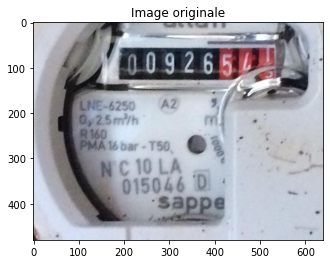

In [73]:
# Plot de l'image originale pour essai

image = cv2.imread(IMG_DIR + '1ec531.jpg')
rgb_img = bgrToRgb(image)
plt.imshow(rgb_img)
plt.title('Image originale')
plt.show()

In [139]:
# Essai de différents preprocess

gray = get_grayscale(image)
rm_noise = remove_noise(gray)
threshOTSU = thresholdingOTSU(gray)
adapthresh = adaptativethresholing(gray)
dilated = dilate(gray)
eroded = erode(gray)
opened = opening(gray)
cannyed = canny(gray)
images = {'orginal': rgb_img,
          'gray': gray,
          'rm_noise': rm_noise,
          'thresholingOTSU': threshOTSU, 
          'adaptative thresholing': adapthresh,
          'dilated': dilated,
          'eroded': eroded,
          'opening': opened, 
          'canny': cannyed}

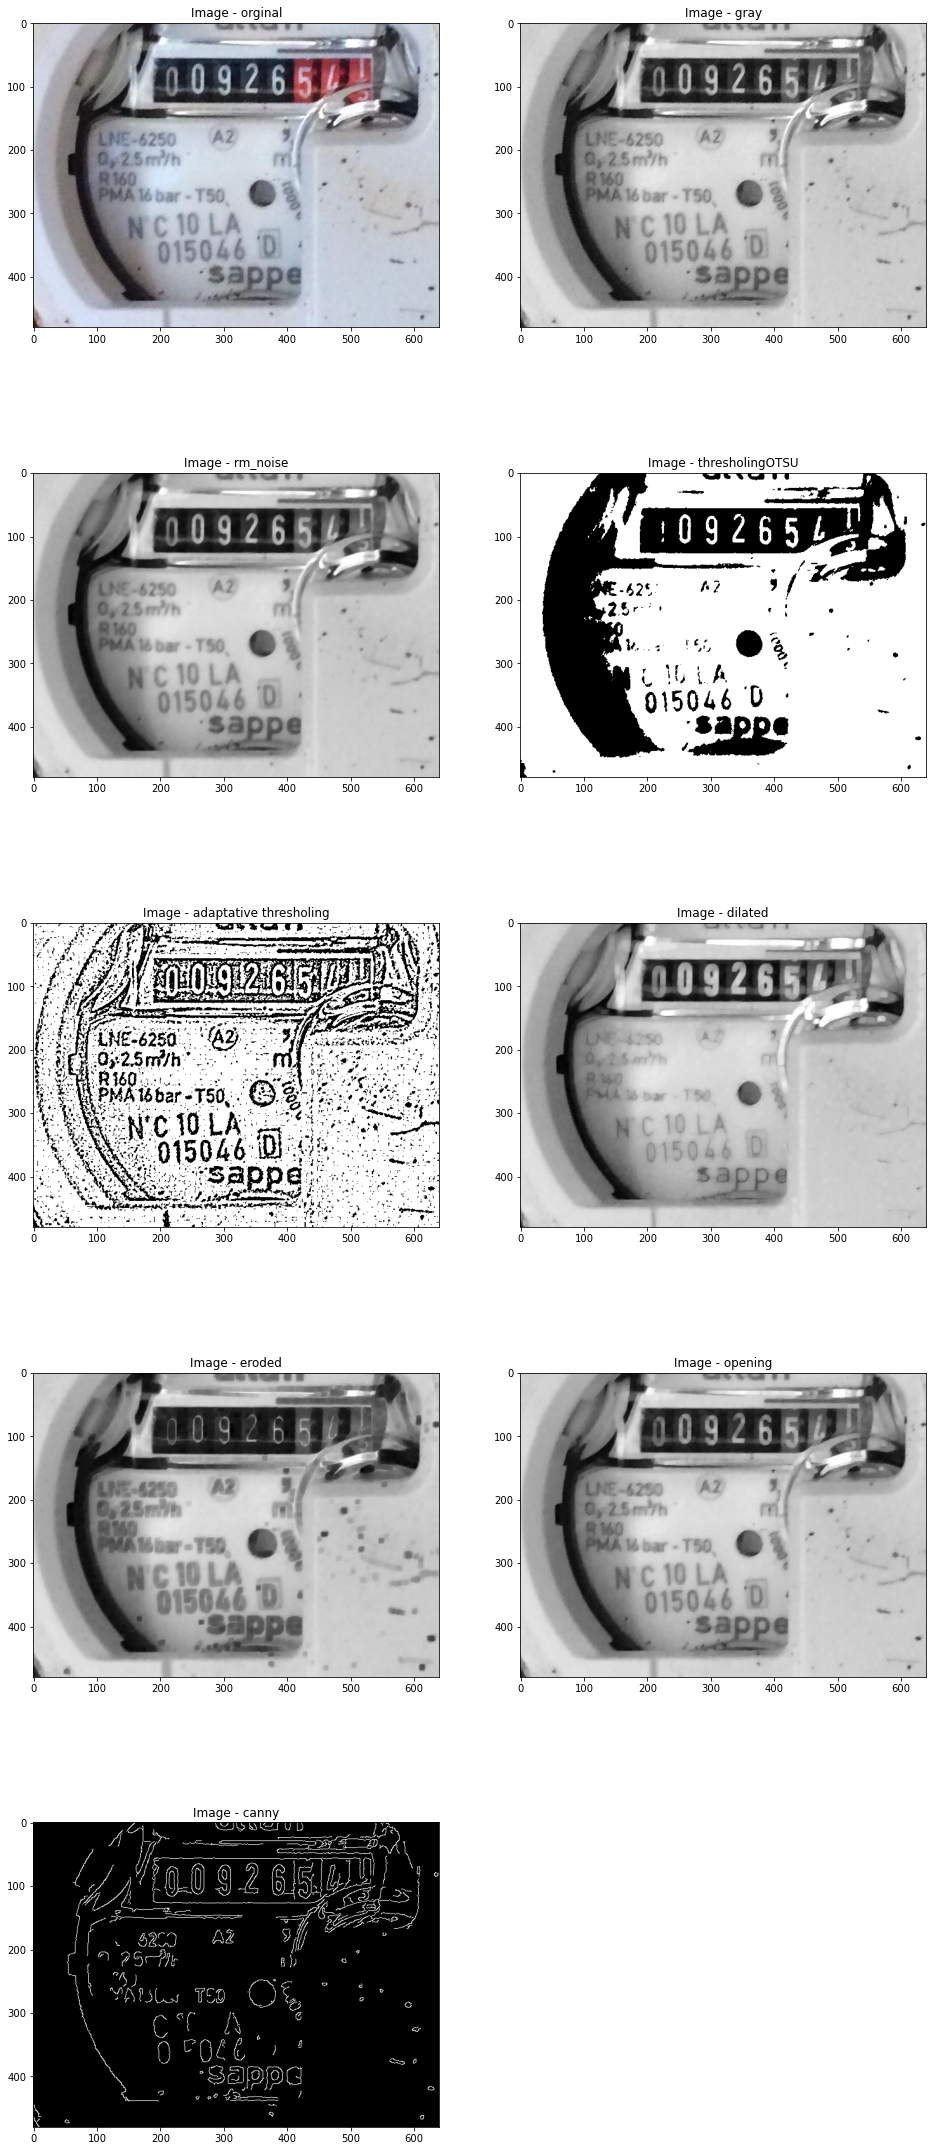

In [140]:
plotimages(images)

On essaie differentes valeurs pour Canny.

In [160]:
canny100200 = canny(gray)
canny100200ap7 = canny(gray, ap = 7)
canny85255 = canny(gray, 85, 255)
canny200255 = canny(gray, 200, 255)
canny300400 = canny(gray, 300, 400)
canny100400 = canny(gray, 100, 400)
canny100500 = canny(gray, 100, 500)
canny300500 = canny(gray, 300, 500)
imagescanny = {'canny100200': canny100200,
          'canny100200ap7': canny100200ap7, 
          'canny85255': canny85255,
          'canny200255': canny200255,
          'canny100400': canny100400,
          'canny300400': canny300400,
          'canny100500': canny100500,
          'canny300500': canny300500}

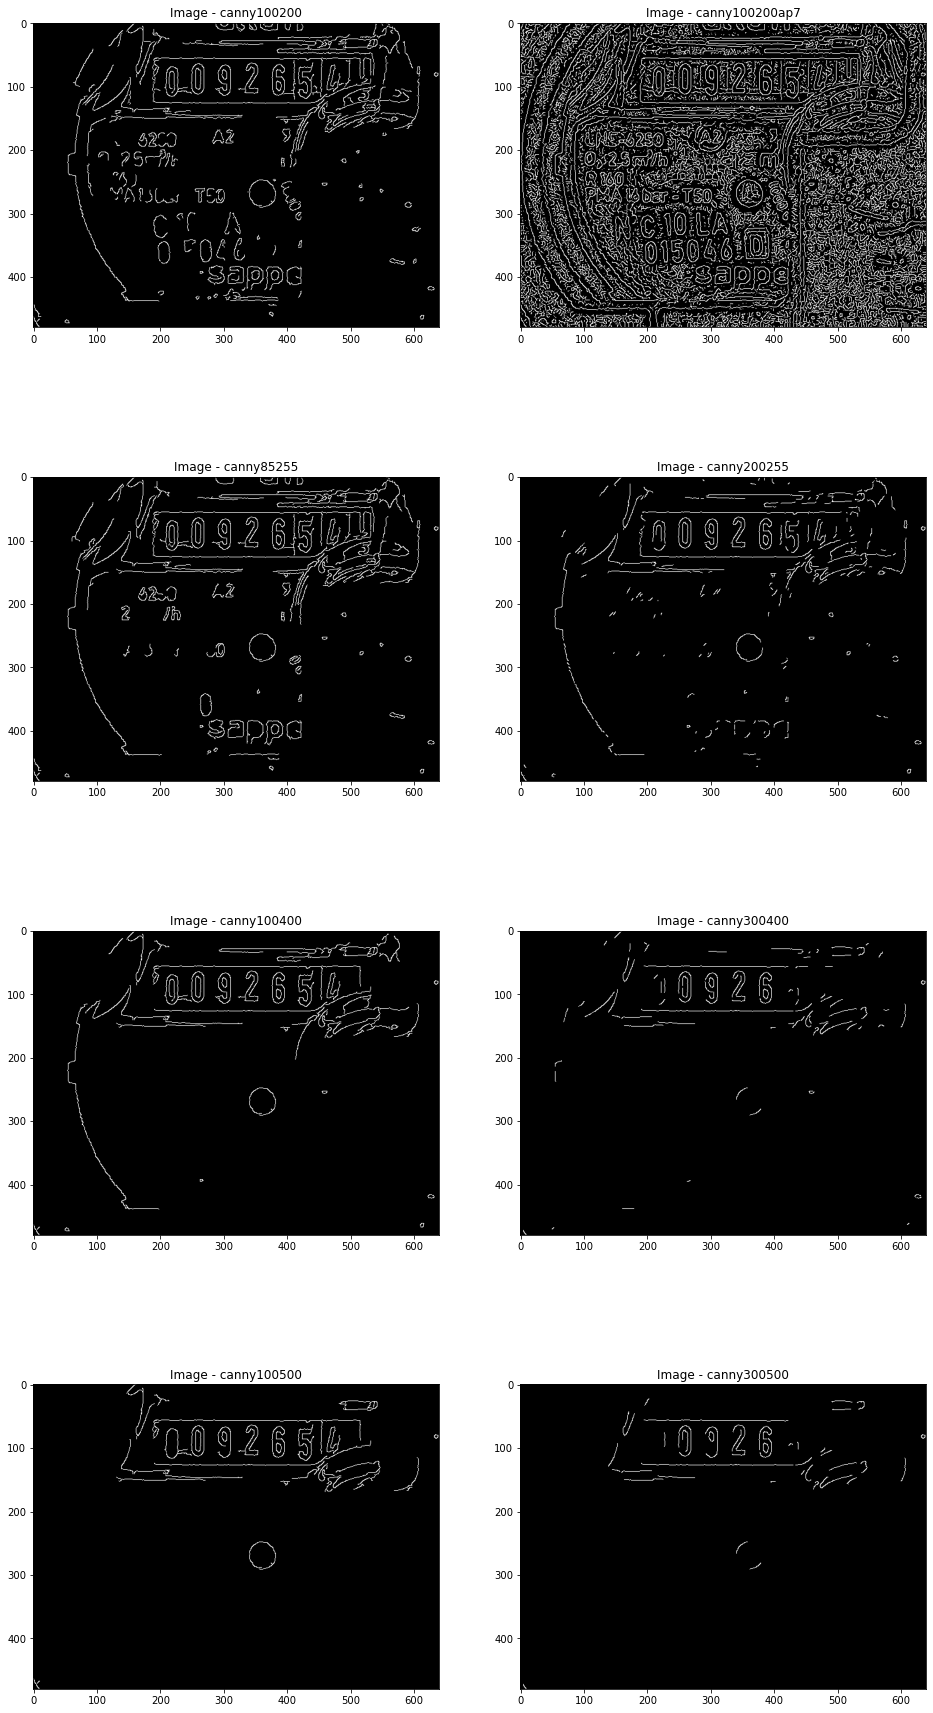

In [161]:
plotimages(imagescanny)

Fonction pour traiter les images mal orientée : 

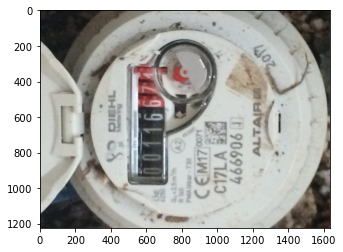

In [24]:
# On prend une image mal orientée pour tester
imagesk = cv2.imread(IMG_DIR + '3beb85.jpg')
rgb_imgsk = bgrToRgb(imagesk)
plt.imshow(rgb_imgsk)
plt.show()

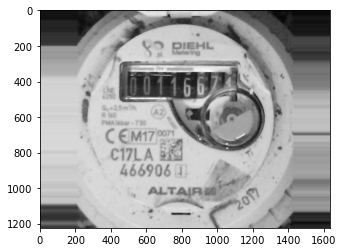

In [26]:
graysk = get_grayscale(imagesk)
graydesk = deskew(graysk)
plt.imshow(graydesk, cmap='gray')
plt.show()

à l'air de fonctionner. Sur plusieurs essais ne fonctionne pas toujours, on fera à la main si besoin.

Tesseract fonctionne bien avec des documents structurés mais sur des images comme celles-ci, il risque de donner de mauvais résultats. Le processus à appliquer serait de d'abord preprocess les images (avec ou sans traitement), puis d'appiliquer un algorhtime d'object detection pour trouver les régions d'intérêt (ROI) et enfin d'appliquer Tesseract sur la zone avec les chiffres pour déterminer la valeur.

On va quand même utiliser Tesseract directement sur les images entières avec les différents filtres pour se donner une première idée.

#### Mode psm

0    Orientation and script detection (OSD) only.  
1    Automatic page segmentation with OSD.  
2    Automatic page segmentation, but no OSD, or OCR.  
3    Fully automatic page segmentation, but no OSD. (Default)  
4    Assume a single column of text of variable sizes.  
5    Assume a single uniform block of vertically aligned text.  
6    Assume a single uniform block of text.  
7    Treat the image as a single text line.  
8    Treat the image as a single word.  
9    Treat the image as a single word in a circle.  
10    Treat the image as a single character.  
11    Sparse text. Find as much text as possible in no particular order.  
12    Sparse text with OSD.  
13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.  

In [61]:
# On tente d'utiliser Pytesseract tel quel sur les images pour voir de premier résultats.
# psm 6 : single uniform block of text
def printTSR(images, config= None):
    if config == None :  
        config = r'--oem 1 --psm 6'
    keys = list(images.keys())
    for i in range(len(keys)):
        print('-----------------------------------------')
        print('Output --> Image ', keys[i])
        print('-----------------------------------------')
        print(pytesseract.image_to_string(images[keys[i]], config=config))

In [133]:
printTSR(images)

-----------------------------------------
Output --> Image  orginal
-----------------------------------------
ne = af ws
iw oar-1s0, ORE :-
oe rt s
015046 D :
ae s
es at . ‘

-----------------------------------------
Output --> Image  gray
-----------------------------------------
| Ey

~625 A2 ' 5 f a a

eS 0r//t "I °

% bar - T50 6% . aa é

L 10 LA p ‘ .

015046 D : ‘i
‘Sappe ‘

ee : 3

-----------------------------------------
Output --> Image  rm_noise
-----------------------------------------
| ET.
250 (AZ if -
2$r% ee
bow -1s0, OE © j
COLA
015046 ae i
+ aahes S

-----------------------------------------
Output --> Image  thresholing
-----------------------------------------
) ER)
826. A? : 5 / se ee
2hro5 4 .
woe 145 @; . to .
u ‘GA . " :
015046 D - ~
‘Sappe .
, : .

-----------------------------------------
Output --> Image  adaptative thresholing
-----------------------------------------
: bf eh ag Wy:
ee peg Li, s ifs lid aye Ni.
(A Ne EN:
| eat ee |
bo LNE-6280 5 "4 3 AF 

#### Seule l'image avec threshold a réussi à isoler un "826" pour le 926.

In [134]:
# psm 3 : Fully automatic page segmentation
config_3 = r'--oem 3 --psm 3'
printTSR(images, config= config_3)

-----------------------------------------
Output --> Image  orginal
-----------------------------------------
 

-----------------------------------------
Output --> Image  gray
-----------------------------------------
=e eee

Leary

 

-----------------------------------------
Output --> Image  rm_noise
-----------------------------------------
 

-----------------------------------------
Output --> Image  thresholing
-----------------------------------------
MAS NO

ey

 

-----------------------------------------
Output --> Image  adaptative thresholing
-----------------------------------------
 

-----------------------------------------
Output --> Image  dilated
-----------------------------------------
~Seere

   

-----------------------------------------
Output --> Image  eroded
-----------------------------------------
 

-----------------------------------------
Output --> Image  opening
-----------------------------------------
  

TS

COLA

.

015046 D x

 
  

---

Aucun résulat

In [135]:
# psm 4 : single column of text of variable sizes
config_4 = r'--oem 3 --psm 4'
printTSR(images, config= config_4)

-----------------------------------------
Output --> Image  orginal
-----------------------------------------
 

-----------------------------------------
Output --> Image  gray
-----------------------------------------
=e eee

09265

 

-----------------------------------------
Output --> Image  rm_noise
-----------------------------------------
 

-----------------------------------------
Output --> Image  thresholing
-----------------------------------------
MAS NO

TErITy

 

-----------------------------------------
Output --> Image  adaptative thresholing
-----------------------------------------
 

-----------------------------------------
Output --> Image  dilated
-----------------------------------------
~Seere

   

-----------------------------------------
Output --> Image  eroded
-----------------------------------------
 

-----------------------------------------
Output --> Image  opening
-----------------------------------------
 

-------------------------------

#### Bonne lecture sur l'image gray

In [136]:
# Sparse text. Find as much text as possible in no particular order. 
config_11 = r'--oem 3 --psm 11'
printTSR(images, config= config_11)

-----------------------------------------
Output --> Image  orginal
-----------------------------------------
= Se =

d<@

625

A2

3 /

250?

va

rs

10 LA

915046 0

$a

-----------------------------------------
Output --> Image  gray
-----------------------------------------
= Se =

WEPTT:

d<¢

A2

=

625

‘ 10 L h

pe.

-----------------------------------------
Output --> Image  rm_noise
-----------------------------------------
= SNe

REPa 1S:

xf

e.

015046 D

-----------------------------------------
Output --> Image  thresholing
-----------------------------------------
MS NS a

TERT

‘=

A?

=

626

v.

4 WG { Ah

re

-----------------------------------------
Output --> Image  adaptative thresholing
-----------------------------------------
Mel Ne

ih

4

Fil

Me

Crees

AGG

Ai

ee

f

er fe

=e

NE-

50

a2

O;25nvh

\ BUR bar -T50,

a

‘CIOLA

015046

Dh)

te

s

appd

-----------------------------------------
Output --> Image  dilated
-------------------------------

In [137]:
# On essaie en autorisant uniquement les nombres + psm 4
config_digits = r'--oem 3 --psm 4 outputbase digits'
printTSR(images, config= config_digits)

-----------------------------------------
Output --> Image  orginal
-----------------------------------------
 

-----------------------------------------
Output --> Image  gray
-----------------------------------------
09265

 

-----------------------------------------
Output --> Image  rm_noise
-----------------------------------------
 

-----------------------------------------
Output --> Image  thresholing
-----------------------------------------
 

-----------------------------------------
Output --> Image  adaptative thresholing
-----------------------------------------
 

-----------------------------------------
Output --> Image  dilated
-----------------------------------------
   

-----------------------------------------
Output --> Image  eroded
-----------------------------------------
 

-----------------------------------------
Output --> Image  opening
-----------------------------------------
 

-----------------------------------------
Output --> Image  can

Comme prévu ça ne marche pas vraiment.

### Utilisation des bounding box 

On essaie d'utiliser Tesseract sans la lecture, seulement la détection d'objets pour trouver les chiffres dans l'image.

In [105]:
# Plot des boîtes autour des caracteres sur l'image

def characBoxes(image):
    new_image = image.copy()
    if len(new_image.shape) ==2 :
        h, w = new_image.shape
    else:
        h, w, c = new_image.shape
    boxes = pytesseract.image_to_boxes(new_image) 

    for b in boxes.splitlines():
        b = b.split(' ')
        new_image = cv2.rectangle(new_image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
    
    return new_image, boxes

def plotImagesCBox(images):
    new_images = {}
    boxess = {}
    keys = list(images.keys())
    for i in range(len(keys)):
        image = images[keys[i]]
        new_image, boxes = characBoxes(image)
        new_images[keys[i]] = new_image
        boxess[keys[i]] = boxes
    plotimages(new_images, cmap = 'plasma')
    return boxess

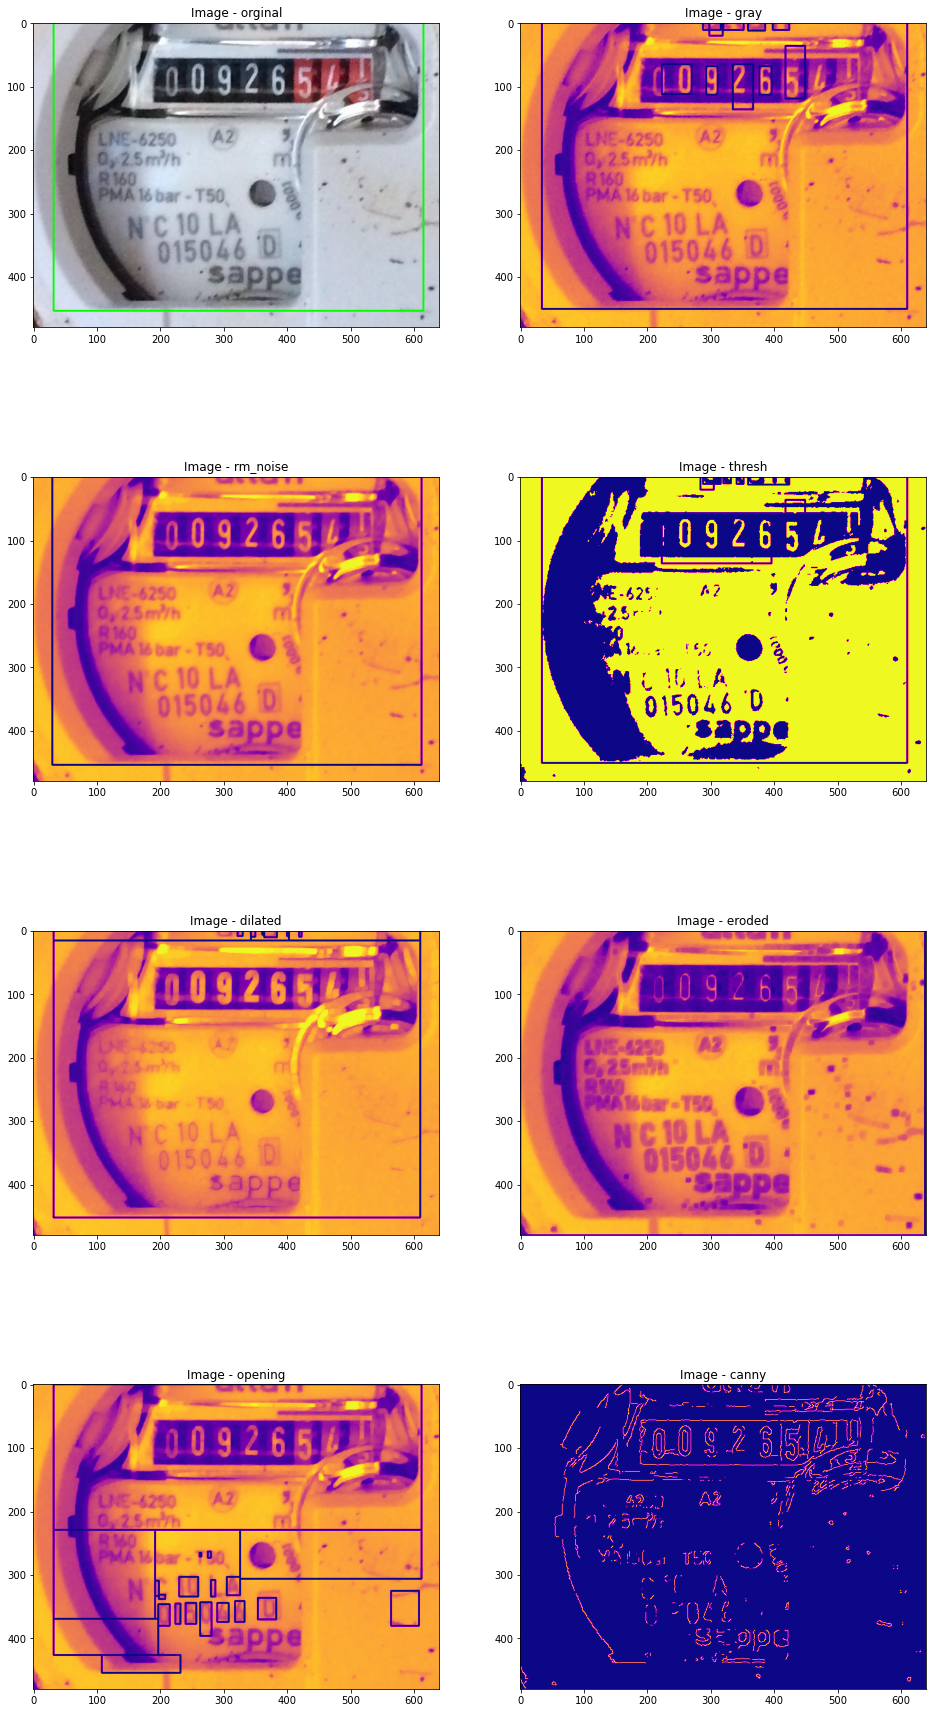

In [111]:
boxess = plotImagesCBox(images)

#### Sur l'image gray, on a des boîtes correctes sur le 0 9 2 6.

In [116]:
# Plot des boîtes autour des mots sur l'image

def wordBoxes(image, conf = 50):
    new_image = image.copy()
    if len(new_image.shape) ==2 :
        h, w = new_image.shape
    else:
        h, w, c = new_image.shape
    data = pytesseract.image_to_data(new_image, output_type=Output.DICT)
    n_boxes = len(data['text'])
    for i in range(n_boxes):
        # On n'affiche que les boxes avec une confiance surpérieure à conf% (50 par défaut)
        if int(data['conf'][i]) > conf:
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            new_image = cv2.rectangle(new_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
 
    return new_image, data

def plotImagesWordBox(images):
    new_images = {}
    datas = {}
    keys = list(images.keys())
    for i in range(len(keys)):
        image = images[keys[i]]
        new_image, data = wordBoxes(image)
        new_images[keys[i]] = new_image
        datas[keys[i]] = data
    plotimages(new_images, cmap = 'plasma')
    return datas


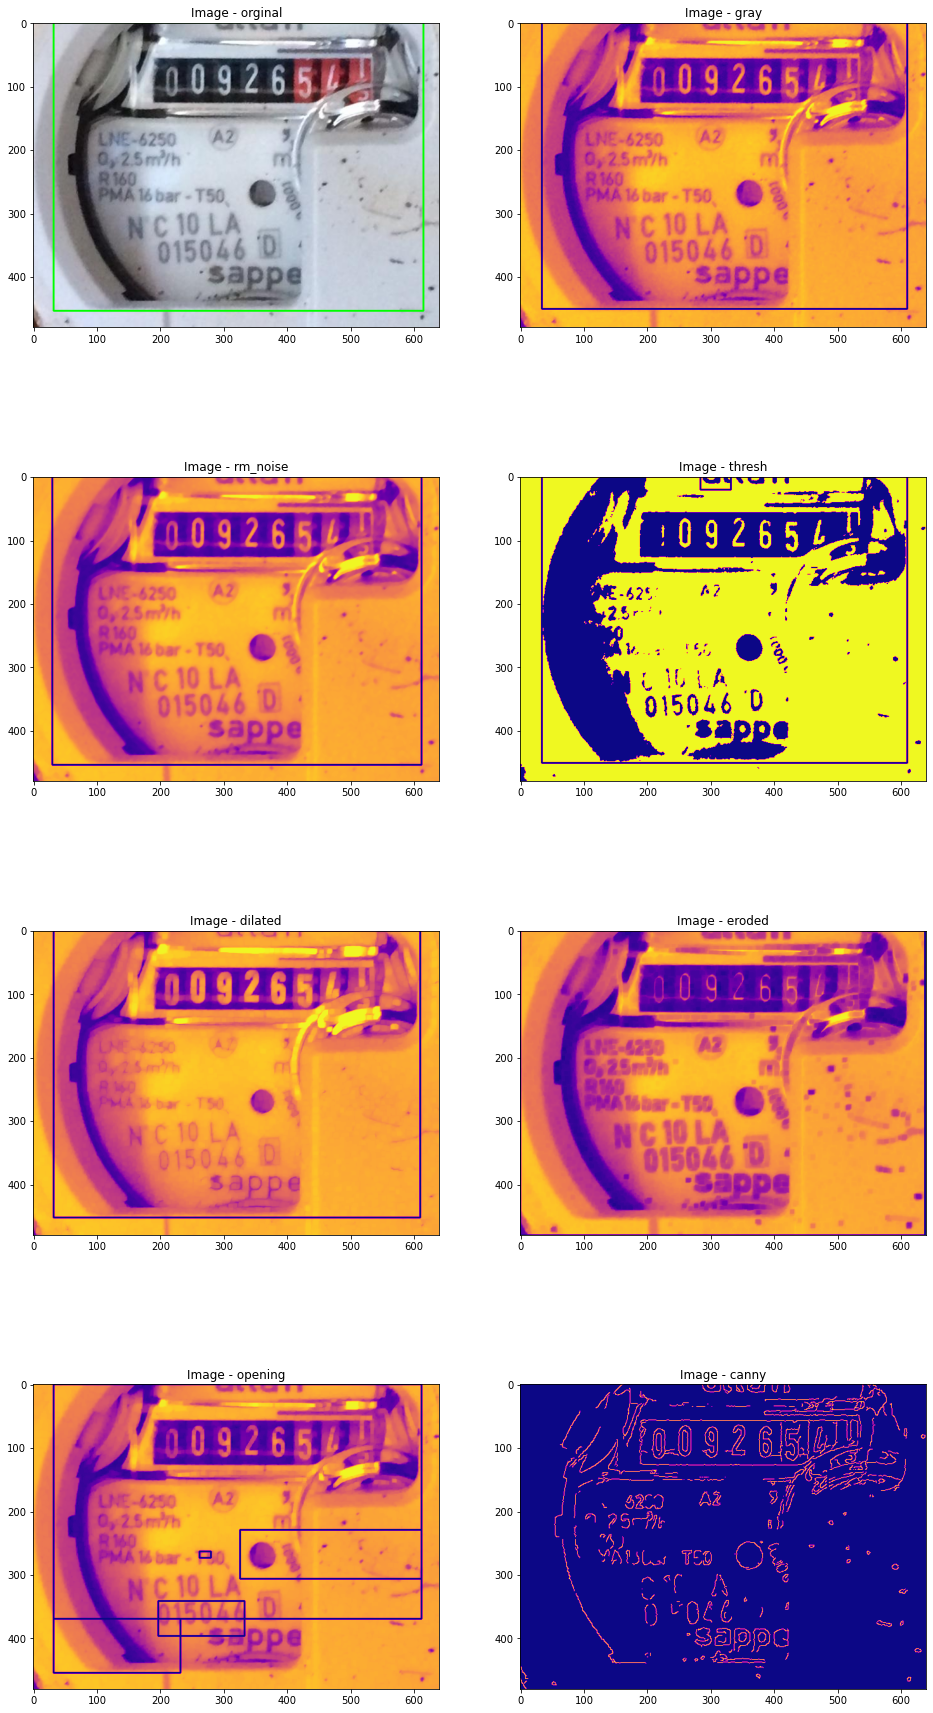

In [117]:
datas = plotImagesWordBox(images)

##### Ça ne marche pas vraiment, la boite encadre presque toute l'image. Sauf avec opening où le nombre apparaisant sur le compteur à été lu.

## On essaye de déterminer les contours du chiffres en utilisant d'abord un filtre canny puis avec la méthode findContours() qui permet de trouver les régions d'intéret (ROI)

In [275]:
# Canny edge pour avoir des contours
edges = cv2.Canny(gray, 120, 280)
copyedges = edges.copy()

# On récupère les contours avec findContours()
#contours, hierarchy = cv2.findContours(copyedges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(copyedges, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

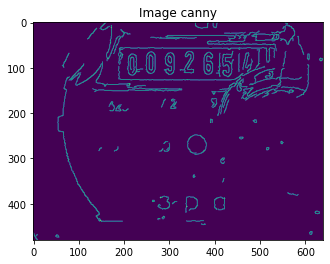

In [276]:
plt.imshow(edges)
plt.title('Image canny')
plt.show()

In [274]:
# En essayant de lire directement
# psm 6 : block de text
custom_config6digit = r'--oem 3 --psm 6 outbase digits'
print(pytesseract.image_to_string(edges, config=custom_config6digit))

- 7
10926



Le "0926" est correctement lu mais il y a un 1 devant et un -7 parasite.

In [277]:
digits = dict()
 
# On récupère les bounding boxes avec une aire de 500 minimum
for (i, c) in enumerate(contours):
    #print(cv2.contourArea(c))
    if cv2.contourArea(c)>500:
        (x, y, w, h) = cv2.boundingRect(c)
        roi = copyedges[y:y + h, x:x + w]
        digits[i] = roi
print(digits.keys())

dict_keys([105, 106, 109, 110])


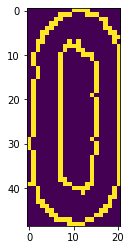

In [281]:
plt.imshow(digits[110])
plt.show()

Les contours d'OpenCv ne fonctionnent pas bien pour cette utilisation. Il va falloir essayer de créer un model d'object détection pour isoler les chiffres dans une bounding box correcte puis les lire.